# 1. Import and config



In [1]:
#from dnndk import n2cube
import numpy as np
from numpy import float32
import os
import cv2
import matplotlib.pyplot as plt
import time

In [2]:

# 训练用的图像尺寸
img_size_net = 128
# 训练的batch大小
batch_size = 32
wordlist = ['angry', 'contemptuous', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
sorts_pathes = ['angry', 'contemptuous', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
run_path = './'

# 存放转换后的tf数据集的路径
# dataset_tf_path_train = run_path + 'datasetTfTrain.tfrecords'
# dataset_tf_path_test = run_path + 'datasetTfTest.tfrecords'
CONV_INPUT_NODE = "x_input_Conv2D"
CONV_OUTPUT_NODE = "y_out_MatMul"

# 2. Loading the dataset

In [3]:
sorts_list = ['angry', 'contemptuous', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
img_size_net = 128
CONV_INPUT = "conv2d_input"
calib_batch_size = 30

def load_valid_data(data_path):
    label_cnt = 0
    test_images = []
    test_lables = []
    for sort_path in sorts_list:    
        flower_list = os.listdir(data_path + sort_path)
        for img_name in flower_list:
            img_path = data_path + sort_path + "/" + img_name
            img = cv2.imread(img_path)  
            img_scale = cv2.resize(img,(img_size_net, img_size_net), interpolation = cv2.INTER_CUBIC)
            if not img is None:
                test_images.append(img_scale / 255.)
                test_lables.append(label_cnt)
        label_cnt += 1             
    return test_images, test_lables

dataset_valid_path = './dataset_valid_FER/'
(validSet_images, validSet_lables) = load_valid_data(dataset_valid_path)
validSet_images = np.array(validSet_images)
validSet_lables = np.array(validSet_lables)
def calib_input(iter):
    images = []
    for index in range(0, calib_batch_size):
        images.append(validSet_images[index])

    return {CONV_INPUT: images}

# 3. Experiment

## 3.1 Load kernel to DPU


In [5]:
# computer setup
import tensorflow as tf
from tensorflow import keras
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True) #

# load model
model = keras.models.load_model('./run/model_two_sep.h5')
# make a prediction
# ynew = model.predict_classes(Xnew)

import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1" # force to use CPU

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
x_input (Conv2D)             (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
separable_conv2d (SeparableC (None, 64, 64, 64)        2400      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 32, 32, 96)        6816      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 96)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 128)       1

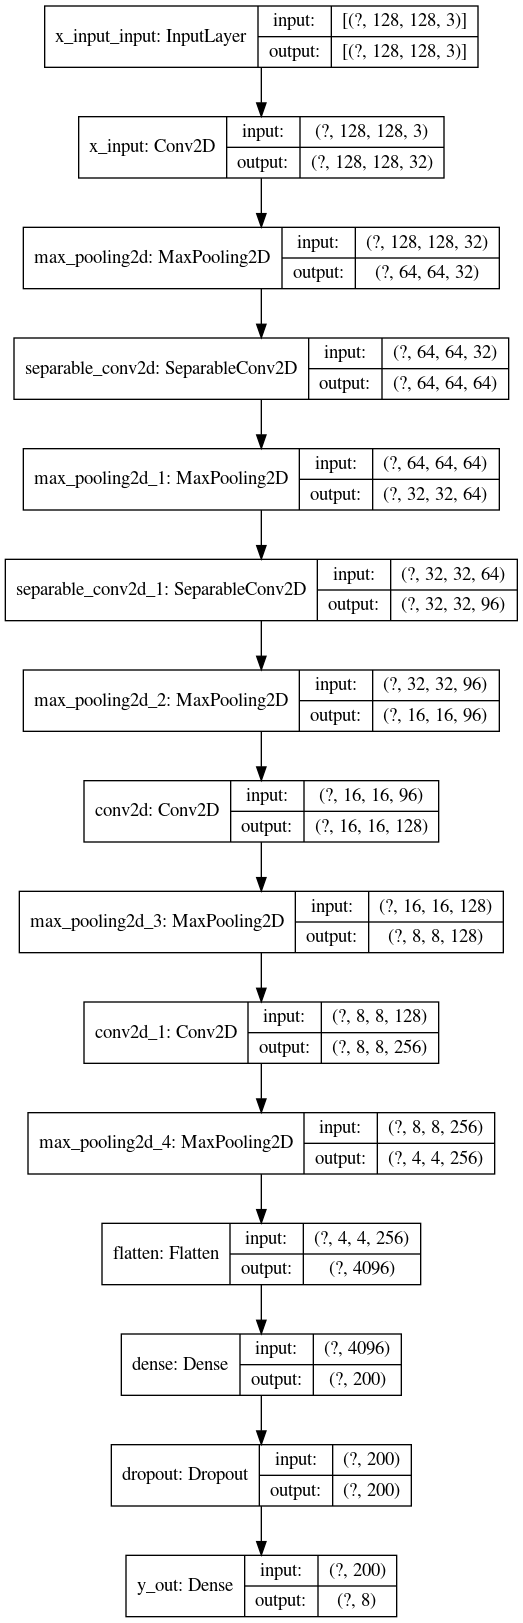

In [14]:
print(model.summary())
dot_img_file = 'model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

## 3.2 Test experiment with valid_dataset


-- %0.02390122413635254 seconds --
-- %0.005242347717285156 seconds --
-- %0.004521846771240234 seconds --
-- %0.007400989532470703 seconds --
-- %0.00414586067199707 seconds --
-- %0.0038259029388427734 seconds --
average inference time 0.008173028628031412 s
FPS 122.35366416927184


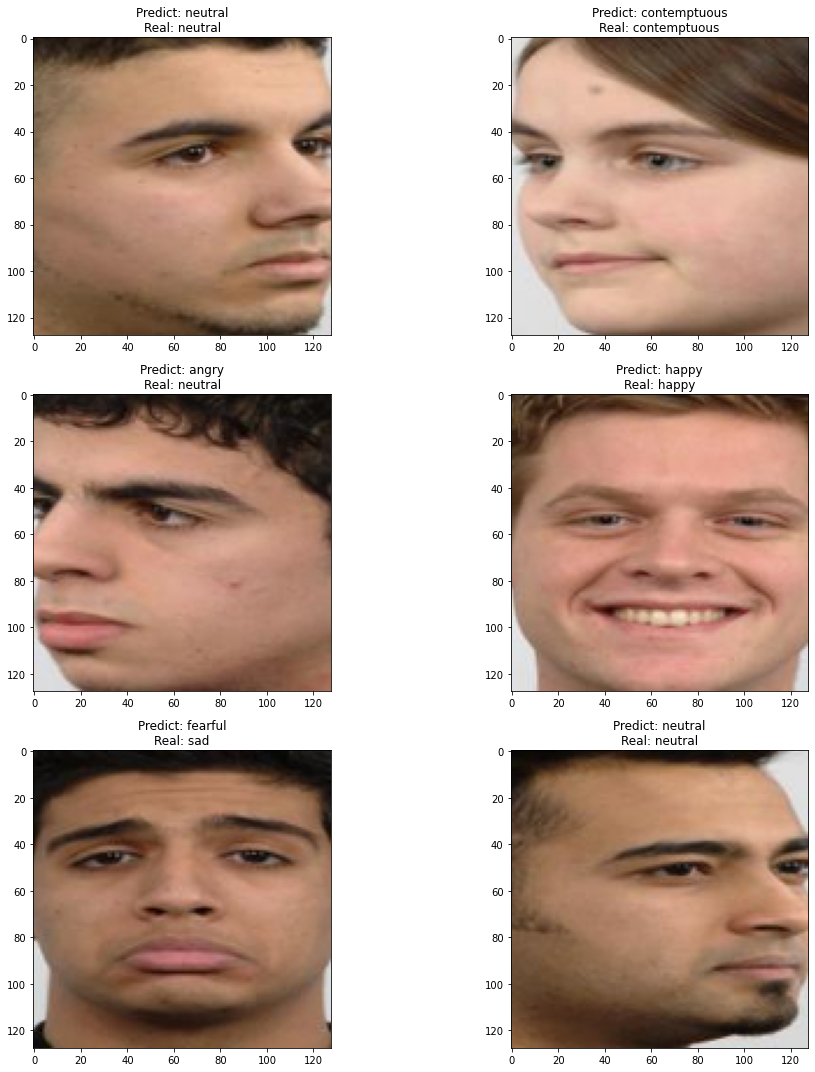

In [16]:
diff_list = []
fig, ax = plt.subplots(3, 2)
fig.set_size_inches(15,15)
for i in range(3):
    for j in range(2):
        l = np.random.randint(0, len(validSet_lables)-1)
        img1_scale = validSet_images[l]
        img1_scale = np.expand_dims(img1_scale, axis=0)
        start = time.time()
        pdt = model.predict_classes(img1_scale)
        end = time.time()
        difference = end - start
        diff_list.append(difference)
        print("-- %{} seconds --".format(difference))
        #pdt = agent1.dpuPredictSoftmax(img1_scale)
        img1_scale = np.array(img1_scale, dtype='float32')
        ax[i, j].imshow(cv2.cvtColor(img1_scale[0], cv2.COLOR_BGR2RGB))
        # print(type(pdt))
        # print(validSet_lables[l])
        title = "Predict: " + wordlist[int(pdt)] + "\n" + "Real: " + wordlist[validSet_lables[l]]
        ax[i, j].set_title(title)
plt.tight_layout()
plt.savefig('result.png')
print('average inference time ' + str(np.mean(diff_list)) + ' s')
print('FPS ' + str(1.0/np.mean(diff_list)))

